## Import Modules

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score,precision_recall_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score

from skopt import BayesSearchCV

from library.sb_utils import save_file

## Load Data

In [2]:
bank_data=pd.read_csv('../data/bank_data_features.csv')

In [3]:
bank_data.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,0,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,0,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,0,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,0,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,0,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


Check out the data type to prepare for the next pre-processing step.

In [4]:
bank_data.dtypes

Attrition_Flag                int64
Customer_Age                  int64
Gender                       object
Dependent_count               int64
Education_Level              object
Marital_Status               object
Income_Category              object
Card_Category                object
Months_on_book                int64
Total_Relationship_Count      int64
Months_Inactive_12_mon        int64
Contacts_Count_12_mon         int64
Credit_Limit                float64
Total_Revolving_Bal           int64
Avg_Open_To_Buy             float64
Total_Amt_Chng_Q4_Q1        float64
Total_Trans_Amt               int64
Total_Trans_Ct                int64
Total_Ct_Chng_Q4_Q1         float64
Avg_Utilization_Ratio       float64
dtype: object

## Train-Test Split

In [5]:
X =bank_data.drop(columns=['Attrition_Flag'])
y =bank_data.Attrition_Flag
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=666,stratify=y)

## Preorocessing

This dataset includes both numerical and categorical features. Most machine learning algorithms require data to be on the same scale for them to be effective, so in here we use StandardSclaler to scale our numerical data. On the other hand, for categorical features, we use one-hot encoding to transform categorical data into numerical so that we can apply our Machine Learning algorithms without any problems.

In [6]:
num_ix = X.select_dtypes(include=['int64', 'float64']).columns
cat_ix = X.select_dtypes(include=['object']).columns

In [7]:
col_transform = ColumnTransformer(transformers=[('cat', OneHotEncoder(), cat_ix), ('num', StandardScaler(), num_ix)])

## Model Selection

We are going to try the following algorithms for our model. Among them, Logistic Regression is gradient descent based algorithm, Random Forest and XGBoost are tree-based, two different kinds of SVM are distance-based.
1. Logistic Regression
2. Random Forest
3. XGBoost
4. SVM with linear kernel
5. SVM with RBF kernel 

At the same time, we will apply Stratified K-Fold Cross Validation on our training data to estimate the skill of our machine learning models.

### Logistic Regression

In [8]:
LR_pipe = Pipeline(steps=[('preprocessor', col_transform),('LR_model', LogisticRegression(max_iter=500, class_weight='balanced'))])

In [9]:
for score in ["roc_auc", "f1", "precision", "recall", "accuracy"]:
    cvs = cross_val_score(LR_pipe, X_train, y_train,  scoring=score, cv=5,n_jobs=-1).mean()
    print("Logistic Regression cross validation", score + " : "+ str(cvs))
    

Logistic Regression cross validation roc_auc : 0.9266460945033751
Logistic Regression cross validation f1 : 0.6357820788145939
Logistic Regression cross validation precision : 0.5102622516022066
Logistic Regression cross validation recall : 0.8434426229508197
Logistic Regression cross validation accuracy : 0.84476629361422


### Random Forest

In [10]:
RF_pipe= Pipeline(steps=[('preprocessor', col_transform), ('RF_model', RandomForestClassifier(class_weight='balanced'))])

In [11]:
for score in ["roc_auc", "f1", "precision", "recall", "accuracy"]:
    cvs = cross_val_score(RF_pipe, X_train, y_train,  scoring=score, cv=5,n_jobs=-1).mean()
    print("Random Forest cross validation", score + " : "+ str(cvs))

Random Forest cross validation roc_auc : 0.9870781099324976
Random Forest cross validation f1 : 0.8149491178029832
Random Forest cross validation precision : 0.9233421898275193
Random Forest cross validation recall : 0.739344262295082
Random Forest cross validation accuracy : 0.9468071099407505


### XGBoost

In [12]:
XGB_pipe= Pipeline(steps=[('preprocessor', col_transform), ('XGB_model', XGBClassifier())])

In [13]:
for score in ["roc_auc", "f1", "precision", "recall", "accuracy"]:
    cvs = cross_val_score(XGB_pipe, X_train, y_train,  scoring=score, cv=5,n_jobs=-1).mean()
    print("XGBoost cross validation", score + " : "+ str(cvs))

XGBoost cross validation roc_auc : 0.9909675345548056
XGBoost cross validation f1 : 0.9062370548645836
XGBoost cross validation precision : 0.9346694495473573
XGBoost cross validation recall : 0.8795081967213114
XGBoost cross validation accuracy : 0.9707702435813035


### SVM with linear kernel

In [14]:
SVMlnr_pipe= Pipeline(steps=[('preprocessor', col_transform), ('SVMlnr', SVC(kernel="linear",class_weight='balanced', C=1))])

In [15]:
for score in ["roc_auc", "f1", "precision", "recall", "accuracy"]:
    cvs = cross_val_score(SVMlnr_pipe, X_train, y_train,  scoring=score, cv=5,n_jobs=-1).mean()
    print("SVM with linear kernel cross validation", score + " : "+ str(cvs))

SVM with linear kernel cross validation roc_auc : 0.926138862102218
SVM with linear kernel cross validation f1 : 0.6350837371564699
SVM with linear kernel cross validation precision : 0.5090251051487797
SVM with linear kernel cross validation recall : 0.8442622950819672
SVM with linear kernel cross validation accuracy : 0.8441079657669519


### SVM with RBF kernel

In [16]:
SVMrbf_pipe= Pipeline(steps=[('preprocessor', col_transform),('SVMrbf', SVC(kernel="rbf",class_weight='balanced'))])

In [17]:
for score in ["roc_auc", "f1", "precision", "recall", "accuracy"]:
    cvs = cross_val_score(SVMrbf_pipe, X_train, y_train,  scoring=score, cv=5,n_jobs=-1).mean()
    print("SVM with RBF kernel cross validation", score + " : "+ str(cvs))

SVM with RBF kernel cross validation roc_auc : 0.9660604307296689
SVM with RBF kernel cross validation f1 : 0.770116082513389
SVM with RBF kernel cross validation precision : 0.6789326208403741
SVM with RBF kernel cross validation recall : 0.8901639344262297
SVM with RBF kernel cross validation accuracy : 0.9145490454246215


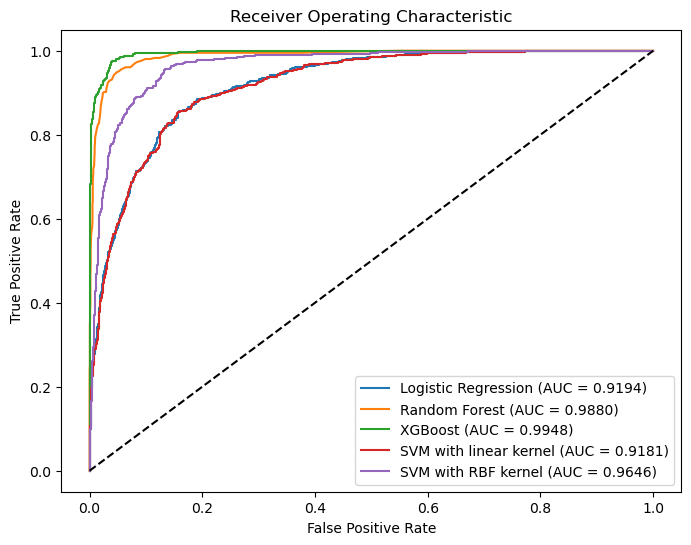

In [18]:

pipelines = [
    ('Logistic Regression', LR_pipe),
    ('Random Forest', RF_pipe),
    ('XGBoost',XGB_pipe),
    ('SVM with linear kernel',SVMlnr_pipe),
    ('SVM with RBF kernel',SVMrbf_pipe)
]

plt.figure(figsize=(8, 6))

for name, pipeline in pipelines:
    pipeline.fit(X_train, y_train)
    
    if hasattr(pipeline, 'predict_proba'):
        y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
    else:
        y_pred_prob = pipeline.decision_function(X_test)  # use decision_function for classifiers without predict_proba
        
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    plt.plot(fpr, tpr, label='{} (AUC = {:.4f})'.format(name, roc_auc))

plt.plot([0, 1], [0, 1], 'k--')  # dashed diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

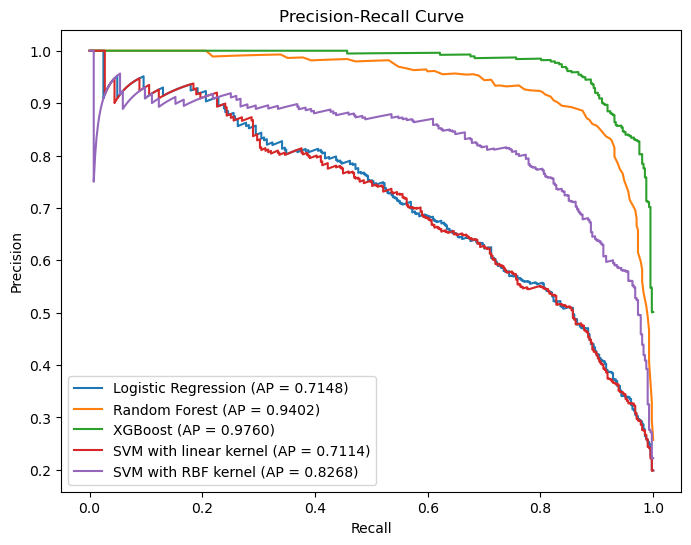

In [19]:

plt.figure(figsize=(8, 6))

for name, pipeline in pipelines:
    pipeline.fit(X_train, y_train)
    
    if hasattr(pipeline, 'predict_proba'):
        y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
    else:
        y_pred_prob = pipeline.decision_function(X_test)  # use decision_function for classifiers without predict_proba
    
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    average_precision = average_precision_score(y_test, y_pred_prob)

    plt.plot(recall, precision, label='{} (AP = {:.4f})'.format(name, average_precision))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

Based on the scores of all models, we find that XGBoost performs the best. Next we are going to tune the XGBoost model to find the optimal values of hyperparameters and maximize the model performance.

## Model Tuning

We choose Bayesian Optimization to tune the model. For XGBoost, we are going to tune the following parameters:<br>
max_depth: Maximum depth of a tree. <br>
gamma: Minimum loss reduction required to make a further partition on a leaf node of the tree. <br>
min_child_weight: Minimum sum of instance weight (hessian) needed in a child. <br>
learning_rate: Step size shrinkage used in update to prevents overfitting. <br>
n_estimators: The number of runs XGBoost will try to learn.<br>

In [1]:
XGB_space = {'XGB_model__max_depth': (3,10), 
             'XGB_model__gamma': (0,5),
             'XGB_model__min_child_weight':(0.5,1), 
             'XGB_model__learning_rate':(0.01,1),
             'XGB_model__n_estimators':(100,500)}

In [21]:
XGB_search = BayesSearchCV( estimator=XGB_pipe,search_spaces=XGB_space,n_iter = 10,n_jobs=-1,cv=5, scoring='f1',
     verbose = 0)

In [22]:
XGB_search.fit(X_train, y_train)


BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('cat',
                                                                          OneHotEncoder(),
                                                                          Index(['Gender', 'Education_Level', 'Marital_Status', 'Income_Category',
       'Card_Category'],
      dtype='object')),
                                                                         ('num',
                                                                          StandardScaler(),
                                                                          Index(['Customer_Age', 'Dependent_count', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon...
                                                       min_child_weight=None,
                                                       missing=nan,
                                        

In [23]:
print(XGB_search.best_score_)
print(XGB_search.best_params_)

0.9142924462924462
OrderedDict([('XGB_model__gamma', 1), ('XGB_model__learning_rate', 0.312337638194264), ('XGB_model__max_depth', 3), ('XGB_model__min_child_weight', 0.5965962605515097), ('XGB_model__n_estimators', 246)])


In [25]:
XGB_tuned= XGB_search.best_estimator_

In [26]:
print(classification_report(y_test, XGB_tuned.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2125
           1       0.94      0.86      0.90       407

    accuracy                           0.97      2532
   macro avg       0.96      0.93      0.94      2532
weighted avg       0.97      0.97      0.97      2532



In [27]:
y_pred_prob = XGB_tuned.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

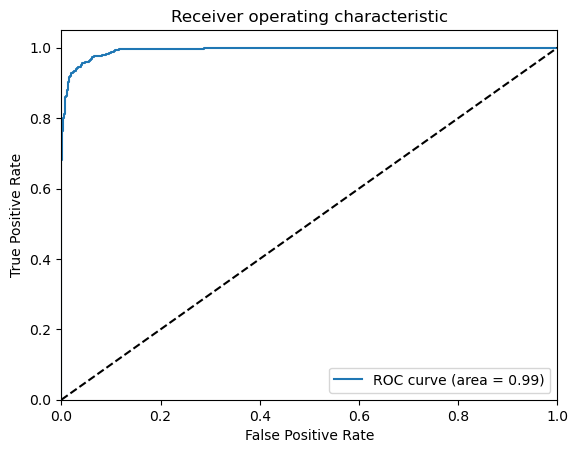

In [28]:
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [31]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)

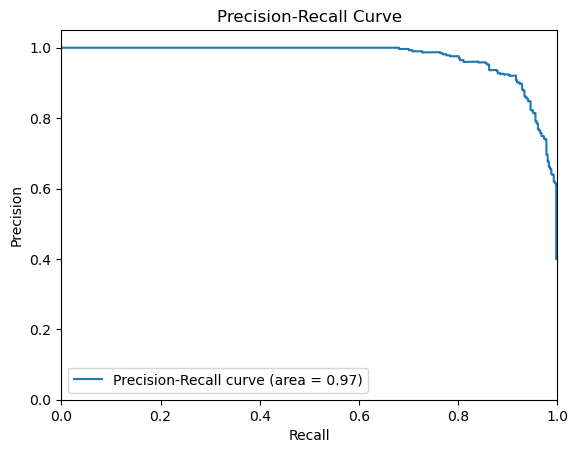

In [32]:
plt.plot(recall, precision, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

## Feature Importance

In [52]:
cat_features=list(XGB_tuned[0].transformers_[0][1].get_feature_names_out())


In [53]:
num_features=list(XGB_tuned[0].transformers_[1][2])

In [54]:
features=cat_features+num_features
features

['Gender_F',
 'Gender_M',
 'Education_Level_College',
 'Education_Level_Doctorate',
 'Education_Level_Graduate',
 'Education_Level_High School',
 'Education_Level_Post-Graduate',
 'Education_Level_Uneducated',
 'Education_Level_Unknown',
 'Marital_Status_Divorced',
 'Marital_Status_Married',
 'Marital_Status_Single',
 'Marital_Status_Unknown',
 'Income_Category_$120K +',
 'Income_Category_$40K - $60K',
 'Income_Category_$60K - $80K',
 'Income_Category_$80K - $120K',
 'Income_Category_Less than $40K',
 'Income_Category_Unknown',
 'Card_Category_Blue',
 'Card_Category_Gold',
 'Card_Category_Platinum',
 'Card_Category_Silver',
 'Customer_Age',
 'Dependent_count',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio']

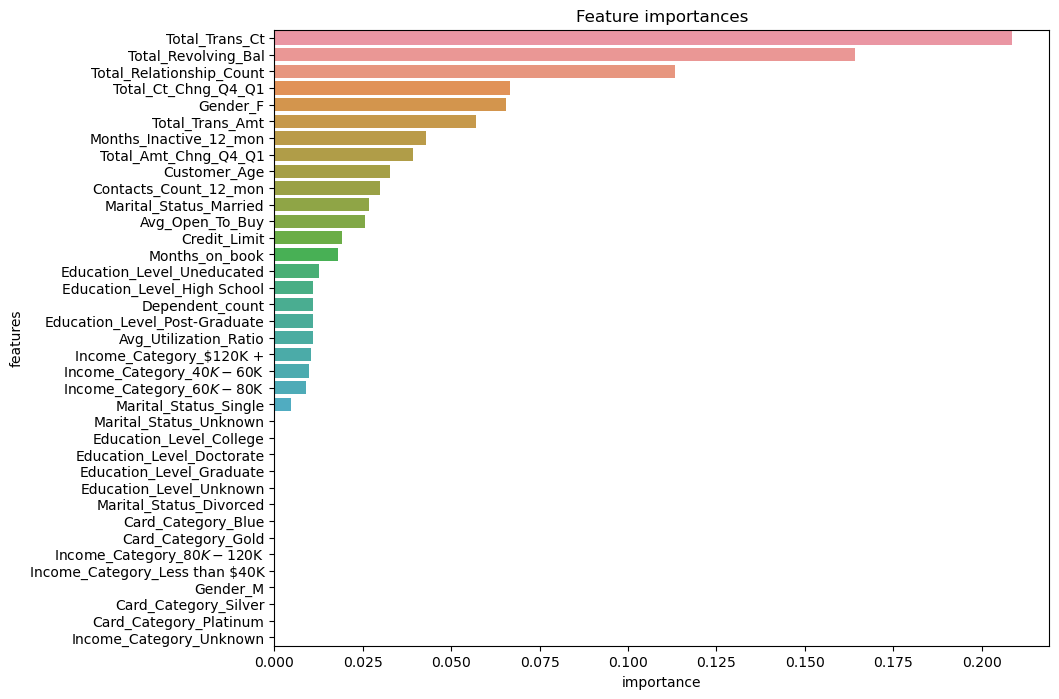

In [55]:
feature_importance=pd.DataFrame(XGB_tuned[1].feature_importances_, columns=['importance'])
feature_importance['features'] =features
plt.figure(figsize=(10,8))
sns.barplot(x='importance', y='features', data=feature_importance.sort_values(by='importance', ascending=False))
plt.title('Feature importances')
plt.show()